In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import gym
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential;
from keras.layers import Dense, Activation;
from keras import initializers;
from keras.optimizers import Adam, SGD;
from keras import backend as K
from tqdm import tqdm, trange
import pandas as pd
%matplotlib inline

c:\users\jacob\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Custom loss function

In [2]:
def loss(Qtarget, Q):
    return K.sum(K.square(Qtarget - Q))

In [3]:
from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
)

$$Q(s,a) = r + \gamma(max(Q(s',a')) \tag{13}$$

In [4]:
def frozen_lake(env, e, learning_rate, gamma, episodes, steps):
    # Initialize history memory
    step_list = []
    reward_list = []
    loss_list = []
    e_list = []

    def create_model():
        initializer = initializers.random_uniform(0, 0.1, seed=1)
        model = Sequential([Dense(4, input_dim=env.observation_space.n, 
                        kernel_initializer=initializer,
                        use_bias=False
                                 )])
        model.compile(loss=loss, optimizer=Adam(lr=learning_rate))
        return model

    model = create_model()

    # Transform into one-hot vector
    def OH(l, x):
        return np.identity(l)[x].reshape(1,l)

    for i in trange(episodes):
        # Initialize
        state = env.reset()
        reward_all = 0 #Reward counter
        done = False
        s = 0 #Step counter
        l = 0 #Loss

        for s in range(steps):
            # Choose action randomly or through agent model
            if np.random.rand(1) < e:
                Q = model.predict(OH(16, state), batch_size=1)
                action = env.action_space.sample()
            else:
                Q = model.predict(OH(16, state), batch_size=1)
                action = np.argmax(Q)

            # Take action and obtain new state and reward    
            new_state, reward, done, _ = env.step(action)

            # Adjust reward if done without reaching end
            if done and reward == 0.0: reward = -1

            # Find max-Q for future state
            Q1 = model.predict(OH(16, new_state), batch_size=1)
            maxQ1 = np.max(Q1)
            
            # Bellman Equation
            # Update target for training by adding reward for action and discounted max next state Q-value
            targetQ = Q
            targetQ[0, action] = reward + (gamma * maxQ1)

            # Train on target Q value
            history = model.fit(OH(16, state), targetQ, verbose=False, batch_size=1)

            # Update history and set current state
            l += history.history['loss'][0]
            reward_all += reward
            state = new_state

            if done == True:
                # Reduce e if current episode is successful
                if reward > 0: 
                    e = 1./((i/50) + 10)
                break

        # Update history
        step_list.append(s)
        reward_list.append(reward_all)
        loss_list.append(l/s)
        e_list.append(e)
    print('\nSuccessful episodes: {}'.format(np.sum(np.array(reward_list)>0.0)/episodes))

    window = int(episodes/10)

    plt.figure(figsize=[9,16])
    plt.subplot(411)
    plt.plot(pd.Series(step_list).rolling(window).mean())
    plt.title('Step Moving Average ({}-episode window)'.format(window))
    plt.ylabel('Moves')
    plt.xlabel('Episode')

    plt.subplot(412)
    plt.plot(pd.Series(reward_list).rolling(window).mean())
    plt.title('Reward Moving Average ({}-episode window)'.format(window))
    plt.ylabel('Reward')
    plt.xlabel('Episode')

    plt.subplot(413)
    plt.plot(pd.Series(loss_list).rolling(window).mean())
    plt.title('Loss Moving Average ({}-episode window)'.format(window))
    plt.ylabel('Loss')
    plt.xlabel('Episode')

    plt.subplot(414)
    plt.plot(e_list)
    plt.title('Random Action Parameter')
    plt.ylabel('Chance Random Action')
    plt.xlabel('Episode')

    plt.tight_layout(pad=2)
    plt.show()
    


### Baseline Not Slippery Lake Version

100%|██████████| 500/500 [00:59<00:00, 29.21it/s]



Successful episodes: 0.504


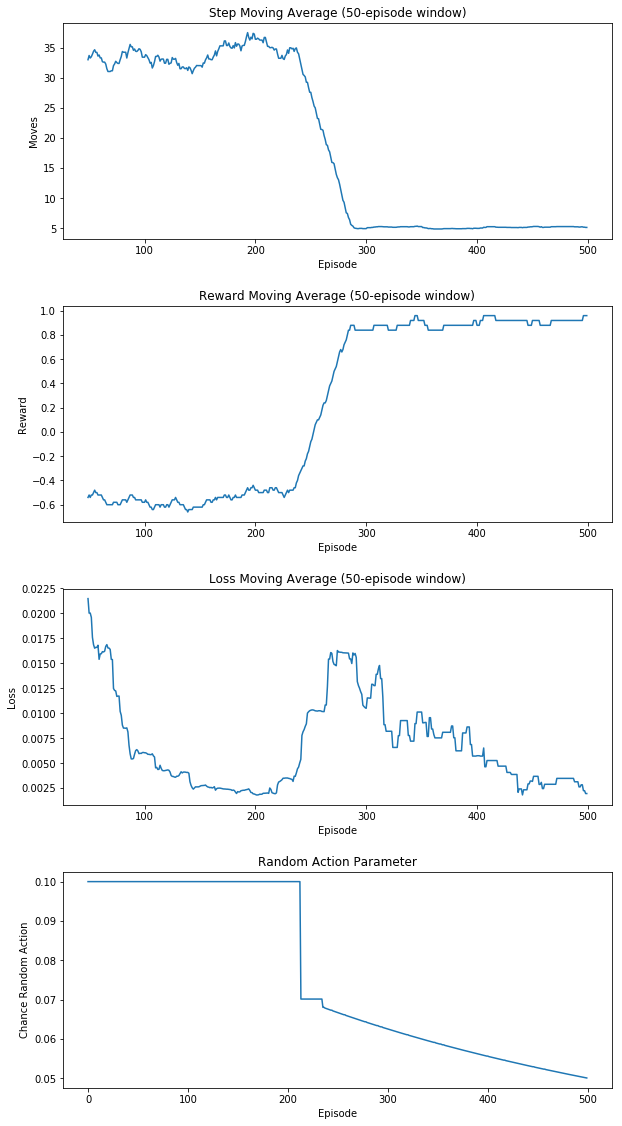

In [5]:
env = gym.make('FrozenLakeNotSlippery-v0')
# Chance of random action
e = 0.1
learning_rate = 0.01
# Discount Rate
gamma = 0.99
# Training Episodes
episodes = 500
# Max Steps per episode
steps = 50

frozen_lake(env, e, learning_rate, gamma, episodes, steps)

### Slippery Lake

100%|██████████| 2000/2000 [06:40<00:00,  4.99it/s]



Successful episodes: 0.4405


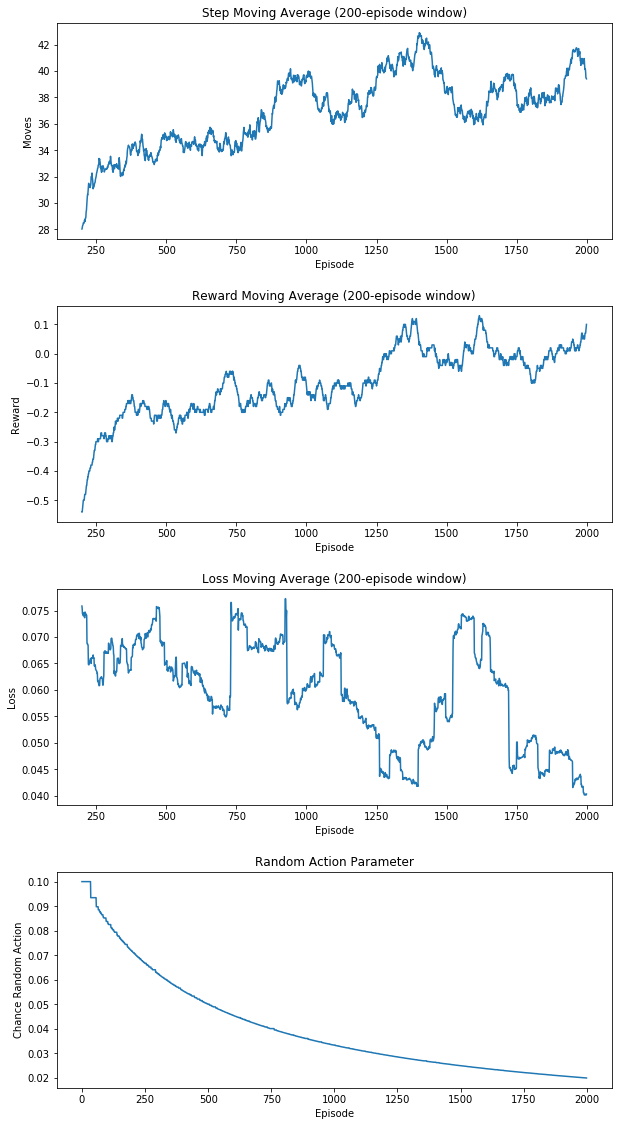

In [6]:
env = gym.make('FrozenLake-v0')
# Chance of random action
e = 0.1
learning_rate = 0.01
# Discount Rate
gamma = 0.99
# Training Episodes
episodes = 2000
# Max Steps per episode
steps = 100

frozen_lake(env, e, learning_rate, gamma, episodes, steps)